### This is the code to run the process, that trains from historic vendor information.
    By : Joseph MTV
    
    Input  : The training file, uploaded by the user.
    Output : The trained model, pickled to a configured "Output" folder.    

### Assumptions:
    => Feed template has an empty row, preceeding the column header. (Changes to this template, will require changes 
       to AppConfig.)
    => Input feed file is an .xlsx file. The active sheet to be considered is to be configured in AppConfig.
    => Footer rows will be dropped.
    => Time period for the current training feed is 4 months. (April 2019 - July 2019)
    => Delivery performance scores are computed for Delivery date and Delivered Qty only.
    => Apply the following weighting rules:
        1. Deviation in dates  * 0.4
        2. Deviation in qty    * 0.4
        3. VendorMaterialCount * 0.2
    => Ranking is done on 
        (Deviation in dates  * 0.4) + (Deviation in qty    * 0.4) + (VendorMaterialCount * 0.2)

### [1.00]: Import the required modules.

In [1]:
# Import the required modules.
import os
import re
import wx             # Install it with pip.
import sys
import json
import shutil         # Install it with pip.
import numpy as np
import pandas as pd
from os import path
from datetime import datetime
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

### [1.10]: Instantiate the ML pipeline class.

#### [1.11]: Prompt for file upload.

In [2]:
# Function to prompt the user to upload the file.
def get_path(wildcard):
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Choose a training file.', wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

#### [1.12] : Instantiate the ML Pipleline class

In [3]:
try:
    # Call the funtion to get the input files.
    #s_infile = get_path('*.csv')
    s_infile = get_path('*.xlsx')
    s_infile = s_infile.replace("\\","\\\\")

    # Get the current working directory.
    s_path = os.getcwd()
    s_path = s_path.replace("\\","\\\\")
    s_basefile = os.path.basename(s_infile)
    s_basefile_csv = (os.path.splitext(s_basefile)[0]) + '.csv'

    # Check, if path exists in system path,else add.
    if s_path in os.environ:
        sys.path.append(s_path)

    # Instantiate and Consume the class.
    from classMLModelingPipeline import *
    # Open and read the App Configuration using json.
    with open(s_path + '\\AppConfig.txt') as json_file:
        # Load the App config details.
        data = json.load(json_file)
        # For each entry in json, extract App config parameters.
        for p in data['AppConfig']:
            applConfig = modMLModelingPipeline  (  p['Id'],
                                                    p['Name'],
                                                    p['Source'],
                                                    p['Output'],
                                                    p['TrainedModel'],
                                                    p['ExecutionLog'],
                                                    p['ExecutionLogFileName'],
                                                    p['FeedActiveSheet'],
                                                    p['FeedSkipRows'],
                                                    p['Archive']
                                                  )
            print(applConfig.Source)
    #===== Create Application Directories ============================================================
    s_classApplication  = 'classMLModelingPipeline'
    s_classMethod       = 'CreateAppDirectories'
    s_statusType        = 'Success'
    s_statusDescription = 'Successfull write operation.'
    applConfig.CreateAppDirectories()
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )
except AttributeError:
    s_statusDescription = 'No file has been choosen!!!!' 
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)
except:
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

C:\Users\HP\DevEnv\Projects\VendorSelection\KPTL_POC\Source\


### [1.20]: Data loading

In [4]:
try:
    s_classMethod       = 'Data Loading'    
    s_statusType        = 'Success'
    feed_active_sheet   = applConfig.FeedActiveSheet
    feed_skiprows       = int(applConfig.FeedSkipRows)
    feed_skiprows_list  = list(range(int(feed_skiprows)))
    if len(feed_skiprows_list) > 0:
        # Read the input file.
        data_xls = pd.read_excel(s_infile, feed_active_sheet, index_col=None,skiprows=feed_skiprows_list)
    else:
        data_xls = pd.read_excel(s_infile, feed_active_sheet, index_col=None)
    # Drop empty rows.
    data_xls.dropna(axis=0,how='any',inplace=True)
    # Get the path to source directory from class.
    s_in_source_file = applConfig.Source
    s_in_source_file = s_in_source_file + s_basefile_csv

    # Convert it to .csv utf-8 format.
    data_xls.to_csv(s_in_source_file, encoding='utf-8')
    
    # Load the data from the csv file into pandas dataframe.
    dfDataVendor = pd.read_csv(s_in_source_file
                               ,parse_dates = ['Doc. Date','Del Date','GRN Date']
                               ,infer_datetime_format = True
                              )
except:
    s_statusType        = 'Error'    
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

In [5]:
try:
    s_classMethod       = 'Drop Unnamed Column'
    s_statusType        = 'Success'
    # Drop the unwanted column.
    dfDataVendor.drop(columns=['Unnamed: 0'],inplace=True)
except KeyError:
    pass
except:
    s_statusType        = 'Error'
    s_statusDescription = 'Unexpected error : ' 
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

### [1.30]: Data pre-processing.

#### [1.31]: Extract VendorCode.

In [6]:
try:
    s_classMethod       = 'Extract Vendor Code'
    s_statusType        = 'Success'    
    # Extract VendorCode from "Supplier/Supplying Plant" column.
    dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('(\d+)')
    # Alternate way:
    #dfDataVendor['VendorCode']  = dfDataVendor['Supplier/Supplying Plant'].str.extract('([0-9][0-9][0-9][0-9][0-9][0-9]+)')
except:
    s_statusType        = 'Error'
    s_statusDescription = s_statusDescription + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

#### [1.32]: Inspect datatypes and perform validation.

In [7]:
def GetValidExceptionForDates(lstDateColumns,  # list of date columns to validate.
                              dfData,          # data frame of the input data.
                              infile_skiprows  # number of rows to skip in the begining from the input file.
                             ):
    # Initialize.
    validationException = ''
    validException_item = ''
    # Corrected Row_index in source file.
    cRowIndex = infile_skiprows + 2
    # Build the Validation Exception message.
    validExceptionPresent = 0
    #validExcept_header = "'ValidationException':"
    validExcept_body   = "'Incorrect_DateFormat' : ["
    validExcept_bodyfooter = "]"
    # Loop through the list of Date columns.
    for itm in lstDateColumns:
        # Validate columns.
        dfDateCheck = pd.to_datetime(dfData[itm],errors='coerce')
        # Get the row indices, where the validation exception occurred.
        lstDateExceptions = list(dfDateCheck[dfDateCheck.isnull()].index+cRowIndex)
        if len(lstDateExceptions) > 0:
            validExceptionPresent = 1
            validException_item = validException_item + "'" + itm + "':" + str(lstDateExceptions) + ","

    if validExceptionPresent:
        # Remove extra comma.
        validException_item = validException_item[:-1]
        # Build the Validation Exception Message.
        validationException = validExcept_body + validException_item + validExcept_bodyfooter
    return validationException

In [8]:
def GetValidExceptionForNumeric(lstNumericColumns,  # list of date columns to validate.
                                dfData,          # data frame of the input data.
                                infile_skiprows  # number of rows to skip in the begining from the input file.
                               ):
    # Initialize.
    validationException = ''
    validException_item = ''
    # Corrected Row_index in source file.
    cRowIndex = infile_skiprows + 2
    # Build the Validation Exception message.
    validExceptionPresent = 0
    #validExcept_header = "'ValidationException':"
    validExcept_body   = "'Incorrect_NumericFormat' : ["
    validExcept_bodyfooter = "]"
    # Loop through the list of Date columns.
    for itm in lstNumericColumns:
        # Validate columns.
        dfNumericCheck = pd.to_numeric(dfData[itm],errors='coerce')
        lstNumericExceptions = list(dfNumericCheck[dfNumericCheck.isnull()].index+cRowIndex)
        if len(lstNumericExceptions) > 0:
            validExceptionPresent = 1
            validException_item = validException_item + "'" + itm + "':" + str(lstNumericExceptions) + ","

    if validExceptionPresent:
        # Remove extra comma.
        validException_item = validException_item[:-1]
        # Build the Validation Exception Message.
        validationException = validExcept_body + validException_item + validExcept_bodyfooter
    return validationException

In [9]:
try:
    # Consolidate error description to write to log.
    #======= Validate Numeric columns ========================================================================================
    raise_Except = 0
    validationException = ''
    strComma = ''
    validExcept_header = "'ValidationException':"
    s_statusType        = 'ValidationException'    
    s_classMethod       = 'Parse Datatypes'
    # Convert date column's datatype from string to datetime.
    lstNumericCols = ['Sum of PO Quantity','Sum of      Net Price','Sum of PO Value', 'Sum of GRN Qty','Sum of GRN Val']
    exceptMessage = GetValidExceptionForNumeric(lstNumericColumns = lstNumericCols, # list of numeric columns to validate.
                                              dfData = dfDataVendor,             # data frame of the input data.
                                              infile_skiprows = feed_skiprows    # number of rows to skip in the begining from the input file.
                                             )
    if len(exceptMessage) > 0:
        raise_Except = 1
        s_statusDescription = exceptMessage

    #======= Validate Date columns =====================================================================================
    # set the class name and status.
    # Convert date column's datatype from string to datetime.
    lstDateCols = ['Doc. Date','Del Date','GRN Date']
    # Get the validation exceptions.
    exceptMessage = GetValidExceptionForDates(lstDateColumns = lstDateCols, # list of date columns to validate.
                                              dfData = dfDataVendor,           # data frame of the input data.
                                              infile_skiprows = feed_skiprows  # number of rows to skip in the begining from the input file.
                                             )
    # If validation exception found.
    if len(exceptMessage) > 0:
        if raise_Except == 1:
            strComma = ','
        raise_Except = 1
        s_statusDescription = s_statusDescription + strComma + exceptMessage
    
    if raise_Except:
        validationException = validExcept_header + '{' + s_statusDescription + '}'
        # Write to log.
        applConfig.WriteToActivityLog(s_classApplication,
                                      s_classMethod,
                                      s_statusType,
                                      s_statusDescription
                                     ) 
        
        raise Exception('Data validation error/s occured. Please check the application log.')
        
except:
    s_statusType        = 'Error'
    s_statusDescription = validationException + str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

#### [1.33]: Export data cleansed, so far to .csv format for inspection.

In [10]:
# Export the date columns to a csv file and manually inspect for anamolies.
dfDataVendor[['GRN Date','Doc. Date','Del Date','VendorCode']].to_csv('Data_Inspect.csv')

dfDataVendorMaxDate = dfDataVendor.copy()

#### [1.34]: Calculate the deviation metrics. Calculate material count supplied by vendor.

In [11]:
try:
    s_classMethod       = 'Calculate deviation metrics'
    s_statusType        = 'Success'    
    # Deviation in expected vs actual delivery dates.
    dfDataVendorMaxDate['Deviation_DeliveryDate'] = (dfDataVendorMaxDate['GRN Date'] - dfDataVendorMaxDate['Del Date']).dt.days

    # Deviation in expected vs actual delivered quantity.
    dfDataVendorMaxDate['Deviation_DeliveredQty'] = (dfDataVendorMaxDate['Sum of PO Quantity'] - dfDataVendorMaxDate['Sum of GRN Qty']) \
    /dfDataVendorMaxDate['Sum of PO Quantity']

    # Round of to the nearest 3rd decimal.
    #dfDataVendorMaxDate['Deviation_DeliveredQty'] = dfDataVendorMaxDate['Deviation_DeliveredQty'].round(3)
    dfDataVendorMaxDate['Deviation_DeliveredQty'] = np.abs(dfDataVendorMaxDate['Deviation_DeliveredQty'].round(3))

    # Deviation in expected vs actual delivered value.
    dfDataVendorMaxDate['Deviation_DeliveredValue'] = (dfDataVendorMaxDate['Sum of PO Value'] - dfDataVendorMaxDate['Sum of GRN Val']) \
    /dfDataVendorMaxDate['Sum of PO Value']

    # Round of to the nearest 3rd decimal.
    #dfDataVendorMaxDate['Deviation_DeliveredValue'] = dfDataVendorMaxDate['Deviation_DeliveredValue'].round(3)
    dfDataVendorMaxDate['Deviation_DeliveredValue'] = np.abs(dfDataVendorMaxDate['Deviation_DeliveredValue'].round(3))

    # Handle negative deviations in quantity and value. Delivered more qty/value than the PO contract.
    dfDataVendorMaxDate.loc[dfDataVendorMaxDate['Deviation_DeliveredQty']   < 0.0,  'Deviation_DeliveredQty'] = 0.0
    dfDataVendorMaxDate.loc[dfDataVendorMaxDate['Deviation_DeliveredValue'] < 0.0,'Deviation_DeliveredValue'] = 0.0
    
    # Get the unique Material/Vendor combo.
    dfMaterialCountByVendor = dfDataVendorMaxDate[['Material','VendorCode']].drop_duplicates()
    # Get distinct material count supplied by Vendor.
    dfMaterialCountByVendor = dfDataVendorMaxDate.groupby(['VendorCode']).agg({'Material':'count'}) \
                                                 .reindex(['Material'],axis=1) \
                                                 .reset_index()
    # Upload to a csv file.
    dfMaterialCountByVendor.to_csv('MaterialSuppliedByVendor.csv')

    # Rename the material column to MaterialCountByVendor in df dfMaterialCountByVendor
    dfMaterialCountByVendor.rename(columns={'Material':'MaterialCountByVendor'}, inplace=True)
    # Update the material count by vendor back to the main dataframe.
    dfDataVendorMaxDate = dfDataVendorMaxDate.merge(dfMaterialCountByVendor,on=['VendorCode'],how='inner')    

except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)    

In [12]:
dfDataVendorMaxDate[['Material','VendorCode','Del Date','GRN Date','Sum of      Net Price', \
                     'Sum of PO Quantity','Sum of PO Value','Sum of GRN Qty','Sum of GRN Val', \
                     'Deviation_DeliveryDate','Deviation_DeliveredQty','Deviation_DeliveredValue','MaterialCountByVendor'
                    ]].to_csv('MaterialVendor_Deviation_Before_Rollup.csv')

#### [1.35]: Get the latest data for multiple vendor occurence for the given snapshot.

In [13]:
try:
    # Avoiding rollup in training phase to enable better learning outcomes.
    s_classMethod       = 'Resolve Multiple Material-Vendor combo'
    s_statusType        = 'Success'    
    dfDataVendorRollup  = dfDataVendorMaxDate[['Material','UOM','VendorCode','Doc. Date','Del Date', \
                                               'GRN Date','Sum of PO Quantity', \
                                               'Sum of      Net Price', \
                                               'Sum of PO Value', \
                                               'Sum of GRN Qty', \
                                               'Sum of GRN Val', \
                                               'Deviation_DeliveryDate', \
                                               'Deviation_DeliveredQty', \
                                               'Deviation_DeliveredValue', \
                                               'MaterialCountByVendor'
                                              ]]
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)

In [14]:
dfDataVendorRollup[['Material','VendorCode','Del Date','GRN Date','Sum of      Net Price', \
                     'Sum of PO Quantity','Sum of PO Value','Sum of GRN Qty','Sum of GRN Val', \
                     'Deviation_DeliveryDate','Deviation_DeliveredQty','Deviation_DeliveredValue','MaterialCountByVendor'
                    ]].to_csv('MaterialVendor_Deviation_After_Rollup_Dates_Maximized_Numeric_Averaged.csv')

### [1.40]: Build the final dataframe for ML modelling.

#### [1.41]: Concatenate all the required columns.

In [15]:
try:
    s_classMethod       = 'Finalize the columns in dataframe.'
    s_statusType        = 'Success'    
    # Concat all the columns required for the analysis.
    dfDataVendorRollup['Deviation_DeliveryDate'] = dfDataVendorRollup['Deviation_DeliveryDate'].round(0)
    dfDataVendorRollup['Deviation_DeliveredQty'] = dfDataVendorRollup['Deviation_DeliveredQty'].round(2)
    dfDataVendorFinal  = dfDataVendorRollup[['Doc. Date','VendorCode','Material','Sum of      Net Price', \
                                            'Sum of GRN Qty','Sum of GRN Val','Sum of PO Quantity','Sum of PO Value', \
                                            'Deviation_DeliveryDate','Deviation_DeliveredQty', \
                                            'Deviation_DeliveredValue','MaterialCountByVendor']].copy()

except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)     

#### [1.42]: Dataframe to contain the delivery performance parameters to be pickled.

In [16]:
dfPickleDeliveryPerformance = dfDataVendorFinal[['Material','VendorCode','Deviation_DeliveryDate',\
                                                 'Deviation_DeliveredQty','Deviation_DeliveredValue', \
                                                 'MaterialCountByVendor']].copy()

#### [1.43]: Generate the class label.

In [17]:
# Function to generate the class Label.
def getClassDelivery(dfClassDelivery):
    # Store the actual index.
    dfIndex = dfClassDelivery.index
    # Set the index to 'Material' to partition the dataset.
    dfClassDelivery.set_index('Material', inplace=True)
    # Loop through the distinct partition value.
    for i in (set(dfClassDelivery.index)):
        # Apply partition, on the 'Material' column.
        slicer = (dfClassDelivery.index.values == i)
        # No deviation in delivery dates and quantity delivered, set the class 
        # label to 1.
        dfClassDelivery.loc[( (slicer) & \
                              (dfClassDelivery['Deviation_DeliveryDate']   <= 0.0) & \
                              (dfClassDelivery['Deviation_DeliveredQty']   == 0.0) \
                             
                            ),  \
                            'classDelivery'] = 1

    dfClassDelivery['Material'] = dfClassDelivery.index
    dfClassDelivery.index = dfIndex
    dfClassDelivery = dfClassDelivery[['Doc. Date','Material','VendorCode','Sum of      Net Price', \
                                       'Sum of GRN Qty','Sum of GRN Val','Sum of PO Quantity','Sum of PO Value', \
                                       'Deviation_DeliveryDate','Deviation_DeliveredQty','MaterialCountByVendor', \
                                       'Rank','classDelivery']]
    return dfClassDelivery

#### [1.44]: Prepare the Class labels

In [18]:
try:
    s_classMethod       = 'Generate Rank and Class Labels'
    s_statusType        = 'Success'        
    # prepare the rank data by hard coding the weights. 
    dfDataVendorFinal['Rank'] = ( (dfDataVendorFinal['Deviation_DeliveryDate']*0.4) + \
                                  (dfDataVendorFinal['Deviation_DeliveredQty']*0.4) + \
                                  (dfDataVendorFinal['MaterialCountByVendor']*0.2) 
                                )

    # Call the function to generate the class label.
    # Set the flag to 'Has Deviation'
    # class_0_Has_Deviation | class_1_Has_No_Deviation
    dfDataVendorFinal['classDelivery'] = 0
    dfDataVendorFinal = getClassDelivery(dfDataVendorFinal.copy())
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)         

In [19]:
dfDataVendorFinal[['Doc. Date','VendorCode','Material','Sum of      Net Price', \
                    'Sum of GRN Qty','Sum of GRN Val','Sum of PO Quantity','Sum of PO Value', \
                    'Deviation_DeliveryDate','Deviation_DeliveredQty','MaterialCountByVendor', \
                    'Rank','classDelivery']].to_csv('MaterialVendor_before_Upsampling.csv')

#### [1.45] : Upsample minority class
#### TO DO LIST :
#### Important Note
    Always split into test and train sets BEFORE trying oversampling techniques! Oversampling before splitting 
    the data can allow the exact same observations to be present in both the test and train sets. 
    This can allow our model to simply memorize specific data points and cause overfitting and 
    poor generalization to the test data.

In [20]:
# Function used to upsample minority class.
def Upsample(dfSample,replace=True):
    dfYOut = dfSample['classDelivery'].value_counts()
    lstClassLabelIndex = list(dfYOut.index)
    lstClassLabelNames = list(dfYOut)
    intDominantClass   = int(lstClassLabelNames[0])

    lstDataframes = []
    for index,classNm in enumerate(lstClassLabelNames):
        #print(index,classNm,lstClassLabelIndex[index])
        dfClassPartition = dfSample[dfSample['classDelivery'] == lstClassLabelIndex[index]]
        if index != 0:
            # Upsample minority class
            dfClassPartition = resample(dfClassPartition, 
                                        replace=replace,     # sample with replacement
                                        n_samples=intDominantClass,    # to match majority class
                                        random_state=123) # reproducible results
        # Append the dataframe to the list
        lstDataframes.append(dfClassPartition)

    # Combine majority class with upsampled minority class
    dfSampleUpsampled = pd.concat(lstDataframes)
    return dfSampleUpsampled

#### [1.46]: Export the data with class Label for analysis.

In [21]:
# Export the data with the assigned class label for inspection.
dfDataVendorFinal[['Material','VendorCode','Sum of      Net Price','Deviation_DeliveryDate', \
                   'Deviation_DeliveredQty','MaterialCountByVendor','Rank','classDelivery']] \
.to_csv('inspect_classAssignment.csv')

### [1.50]: Treat categorical variables.

In [22]:
try:
    s_classMethod       = 'Treat Categorical Varaibles'
    s_statusType        = 'Success' 
    # Build the dataframe with the encoded column for the categorical data.
    dfMaterialOHE = pd.get_dummies(dfDataVendorFinal['Material'])
    dfVendorOHE   = pd.get_dummies(dfDataVendorFinal['VendorCode'])
    # Add the encoded columns to the existing upsampled dataframe.
    dfDataVendorFinal = pd.concat([dfDataVendorFinal,dfMaterialOHE,dfVendorOHE],axis=1)    
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)         

In [23]:
dfDataVendorFinal['classDelivery'].value_counts()
#class_1 : 14%
#class_0 : 86%

0    647
1    105
Name: classDelivery, dtype: int64

### [1.60]: Machine Learning Modelling

#### [1.61]: Split the dataset into training, cross-validation and test.

In [24]:
try:
    s_classMethod       = 'Perform Data Split'
    s_statusType        = 'Success' 

    # Copy the dataframe.
    dfDataVendorML = dfDataVendorFinal.copy()

    # Extract the dependent variable.
    Y_Output = dfDataVendorML[['classDelivery']].copy()
    # Remove features not useful for the modelling.
    featureDrop = ['classDelivery', \
                   'Doc. Date', \
                   'Material', \
                   'VendorCode', \
                   'Rank' \
                   ,'Sum of      Net Price' \
                   ,'Sum of PO Quantity' \
                   ,'Sum of PO Value' \
                   ,'Sum of GRN Qty' \
                   ,'Sum of GRN Val'
                   ,'MaterialCountByVendor'
                   ]
    dfDataVendorML.drop(featureDrop, axis=1,inplace=True)
    # Extract the independent variable.
    X_Input = dfDataVendorML.copy()

    # Get the total row count.
    total_rowCount = len(X_Input)
    # Is time based splitting of dataset required.
    IsTimeBasedSplitting = 0
    # Data split ratio for train, cv and test set.
    Training_split_ratio = 0.60
    Crossvalidation_split_ratio = 0.20
    Test_split_ratio = 0.20

    # Call the method to split the data.
    X_train,X_cv,X_test,Y_train,Y_cv,Y_test = applConfig.split_data(dfX = X_Input,
                                                                    dfY = Y_Output,
                                                                    total_rowCount = total_rowCount,
                                                                    IsTimeBasedSplitting = IsTimeBasedSplitting,
                                                                    Training_split_ratio = Training_split_ratio,
                                                                    Crossvalidation_split_ratio = Crossvalidation_split_ratio,
                                                                    Test_split_ratio = Test_split_ratio)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)             

#### [1.62]: Upsample the minority class in the training set.

In [25]:
'''
# Merge the input and output before upsamping the minority class.
dfTrainUpsampled = pd.concat([X_train,Y_train],axis=1)    
# Upsample the minority class.
dfTrainUpsampled = Upsample(dfTrainUpsampled,replace=True)
# Split the input and output features into separate dataframes.
Y_train = dfTrainUpsampled['classDelivery']
X_train = dfTrainUpsampled.drop('classDelivery', axis=1,inplace=False)
'''

"\n# Merge the input and output before upsamping the minority class.\ndfTrainUpsampled = pd.concat([X_train,Y_train],axis=1)    \n# Upsample the minority class.\ndfTrainUpsampled = Upsample(dfTrainUpsampled,replace=True)\n# Split the input and output features into separate dataframes.\nY_train = dfTrainUpsampled['classDelivery']\nX_train = dfTrainUpsampled.drop('classDelivery', axis=1,inplace=False)\n"

In [26]:
#Y_train.value_counts()
print(Y_train['classDelivery'].value_counts())
print(Y_cv['classDelivery'].value_counts())
print(Y_test['classDelivery'].value_counts())

0    386
1     65
Name: classDelivery, dtype: int64
0    128
1     22
Name: classDelivery, dtype: int64
0    133
1     18
Name: classDelivery, dtype: int64


#### [1.62]: Standardize the data.

In [27]:
try:
    s_classMethod       = 'Perform Data Split'
    s_statusType        = 'Success' 
    IsNormalize         = 1
    
    # Standardize the data.
    normalizer,X_train_stdzd,X_cv_stdzd, X_test_stdzd, \
    Y_train_ravel,Y_cv_ravel,Y_test_ravel = applConfig.standardize_data( X_train,
                                                                         X_cv,
                                                                         X_test,
                                                                         Y_train,
                                                                         Y_cv,
                                                                         Y_test,
                                                                         IsNormalize=IsNormalize)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)             

#### [1.63]: Hyper-parameter Tuning

In [28]:
try:
    s_classMethod       = 'Perform Hyper-parameter tuning'
    s_statusType        = 'Success' 

    # Set the parameters to determine the model hyper parameters.
    classWt = 1      # 0=>None|1=>Balanced
    penalty = 'l2'   # optimizer
    cv      = 5      # Sampling epochs.
    solver  = 'liblinear' # Solver.

    # Get the model hyper-parameters.
    gridResults,bestScore, \
    optimal_HyperParameter = applConfig.GetModelHyperParameters(X_train_stdzd
                                                                ,Y_train_ravel
                                                                ,penalty  # Optimizer.
                                                                ,cv       # GridSearchCV cv sample size
                                                                ,classWt  # class-weight: 0=>None|1=>'balanced'
                                                                ,solver # solver.
                                                               )
    print(gridResults)
    print(bestScore)
    print(optimal_HyperParameter)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)                 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.8337028824833703
10000000


#### [1.64]: Model Training

classWt==balanced


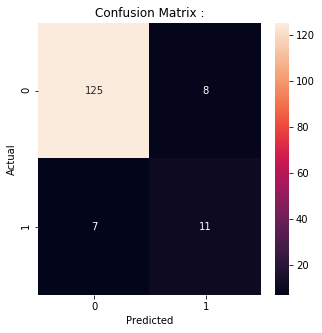

In [29]:
try:
    s_classMethod       = 'Perform Model training'
    s_statusType        = 'Success' 

    # Get the trained model with the optimal hyperparameter.
    lr_optimal = applConfig.GetTrainedModel(X_train_stdzd,
                                            Y_train_ravel,
                                            optimal_HyperParameter,
                                            penalty,     # Optimizer
                                            solver,      # Solver
                                            classWt      # classWeight
                                           )

    # Get the calibrated model.
    calibratedCCV = applConfig.GetCalibratedModel( lr_optimal,
                                                   X_train_stdzd,
                                                   Y_train_ravel)

    # Get the predictions from the test set.
    Y_pred_test = applConfig.GetPredictions( lr_optimal,
                                             X_test_stdzd)

    # Get the calibrated predictions from the test set.
    Y_pred_calib = applConfig.GetCalibratedPredictions( calibratedCCV,
                                                        X_test_stdzd)

    # Get the model confusion matrix
    #tickLabels = ['Deviation','No Deviation']
    plt , confmat, \
    tn, fp, fn, tp = applConfig.GetModelConfusionMatrixForBinaryClass(Y_test,
                                                                      Y_pred_test)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)  

In [30]:
# Weights of the learnt model.
print(lr_optimal.coef_.shape)
print(X_train_stdzd.shape)
print(X_cv_stdzd.shape)
print(X_test_stdzd.shape)
print(len(X_Input))
print(len(Y_Output))
X_Input.columns

(1, 414)
(451, 414)
(150, 414)
(151, 414)
752
752


Index(['Deviation_DeliveryDate', 'Deviation_DeliveredQty', '272TWROSHT',
       '272TWROSMS', 'HT1-100X100X10', 'HT1-100X100X10P', 'HT1-100X100X6',
       'HT1-100X100X6P', 'HT1-100X100X7', 'HT1-100X100X7P',
       ...
       '201039', '201262', '201356', '201373', '201386', '201420', '3801013',
       '3801809', '3808130', '5313755'],
      dtype='object', length=414)

#### [1.65]: Model Evaluation

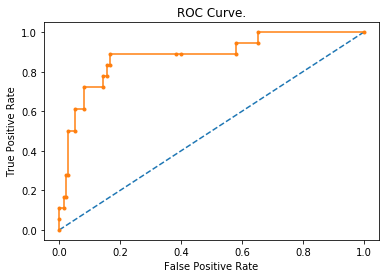

In [31]:
try:
    s_classMethod       = 'Perform Model evaluation'
    s_statusType        = 'Success' 
    
    # Plot the Roc curve
    # Get the actual class distribution from the test set.
    negative_class = Y_test['classDelivery'].value_counts()[0]
    positive_class = Y_test['classDelivery'].value_counts()[1]
    #print("Actual Negative Class: ",negative_class)
    #print("Actual Positive Class: ",positive_class)

    # Get the ROC value.
    plt,roc_score = applConfig.GetModelROCForBinaryClass(Y_test_ravel,Y_pred_calib)
    plt.show()

    #print("ROC AUC Score:",roc_score)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)      

#### [1.66]: Write Model Metrics To Log.

In [32]:
try:
    s_classMethod       = 'Log Model Metrics'
    s_statusType        = 'Success'
    
    # Generate Model trace.
    # Set the model trace parameters.
    modelTrace = "[ModelHyperParameters]:[" + str(gridResults) + "];"
    modelTrace = modelTrace + "[ModelOptimalHyperParameter]:[" + str(optimal_HyperParameter) + "];"
    modelTrace = modelTrace + "[Class_Labels]:[0|1];"
    modelTrace = modelTrace + "[ModelConfusionMatrix]:[" + str(confmat) + "];"
    modelTrace = modelTrace + "[ModelROC_AUC]:[" + str(roc_score) + "];"
    modelTrace = modelTrace + "[Actual_ClassDistribution]:[" + str(positive_class) + "|" + str(negative_class) + "];"

    # Call method to write the model trace to log.
    applConfig.WriteToActivityLog(classApplication  = s_classApplication,
                                  classMethod       = 'Log Model Metrics',
                                  statusType        = 'Success',
                                  statusDescription = modelTrace)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)  

#### [1.67]: Pickle the trained model.

In [33]:
try:
    s_classMethod       = 'Pickle Trained Model'
    s_statusType        = 'Success'
    # Pickle the standardizer.
    pklTrainedStandardizer = applConfig.PickleTrainedObject('TN',normalizer)
    # Pickle the trained Model.
    pklTrainedModel = applConfig.PickleTrainedObject('TM',lr_optimal)
    #print(pklTrainedModel)
    pklTrainedCalibratedModel = applConfig.PickleTrainedObject('TCM',calibratedCCV)
    #print(pklTrainedCalibratedModel)
    pklDeliveryPerformanceParameters = applConfig.PickleDataframes(dfPickleDeliveryPerformance)
    #print(pklDeliveryPerformanceParameters)
except:
    s_statusType        = 'Error'
    s_statusDescription = str(sys.exc_info())
    applConfig.WriteToActivityLog(s_classApplication,
                                  s_classMethod,
                                  s_statusType,
                                  s_statusDescription
                                 )    
    raise Exception(s_statusDescription)  